In [5]:
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from LSTM import *
from LSTMbis import *
import pandas as pd
import numpy as np
import torch.utils.data as utils
import time

import pdb

torch.manual_seed(1)

In [6]:
import os
data = {}
a=0
for j in range(1,7):
    for i in os.listdir('./new_data/%s'%j):
        if i.endswith('.txt'):
            a = a+1
            data['%s'%a] = pd.read_csv('new_data/{}/{}'.format(j,i), header = None, 
                                        names = ['frameNb','id', 'x','y','Vx','Vy'],
                                           delimiter=' ')

In [40]:
a = 0
inputs = np.zeros([len(data),10,2])
gt = np.zeros([len(data),10,2])
in_coord = np.zeros([len(data),10,2])
gt_coord = np.zeros([len(data),11,2])

for i in data:
    inputs[a,:,:] = np.array(data['%s'%i].loc[0:9,['Vx','Vy']])
    gt[a,:,:] = np.array(data['%s'%i].loc[10:19,['Vx','Vy']])
    in_coord[a,:,:] = np.array(data['%s'%i].loc[0:9,['x','y']])
    gt_coord[a,:,:] = np.array(data['%s'%i].loc[9:19,['x','y']])
    a +=1

In [57]:
mask = list(range(len(inputs)-100, len(inputs)))
x_val = inputs[mask]
y_val = gt[mask]
mask = list(range(len(inputs)-100))
x_train = inputs[mask]
y_train = gt[mask]

x_train,y_train = torch.from_numpy(x_train).type(torch.FloatTensor), torch.from_numpy(y_train).type(torch.FloatTensor)
x_val,y_val = torch.from_numpy(x_val).type(torch.FloatTensor), torch.from_numpy(y_val).type(torch.FloatTensor)

x_train = x_train.unsqueeze(1) # add 1 dimension to the training set
y_train = y_train.unsqueeze(1) # add 1 dimension to the training set
x_val = x_val.unsqueeze(1) # add 1 dimension to the validation set
y_val = y_val.unsqueeze(1) # add 1 dimension to the validation set

print('Train data shape: ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', x_val.shape)
print('Validation labels shape: ', y_val.shape)

traindataset = utils.TensorDataset(x_train, y_train)
trainloader = utils.DataLoader(traindataset, batch_size=5, shuffle=True)

valdataset = utils.TensorDataset(x_val, y_val)
valloader = utils.DataLoader(traindataset, batch_size=5, shuffle=True)

Train data shape:  torch.Size([4826, 1, 10, 2])
Train labels shape:  torch.Size([4826, 1, 10, 2])
Validation data shape:  torch.Size([100, 1, 10, 2])
Validation labels shape:  torch.Size([100, 1, 10, 2])


In [48]:
class ConvNet(nn.Module):
    def __init__(self, n_input_channels=1, n_output=None):
        super().__init__()
        ################################################################################
        # TODO:                                                                        #
        # Define 2 or more different layers of the neural network                      #
        ################################################################################
        
        self.conv1 = nn.Conv2d(n_input_channels,3,5,padding=2)
        self.conv1_bn = nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
     
        self.fc1 = nn.Linear(10*2 * 3, 10*2 * 1)
        
        
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
    
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Set up the forward pass that the input data will go through.                 #
        # A good activation function betweent the layers is a ReLu function.           #
        #                                                                              #
        # Note that the output of the last convolution layer should be flattened       #
        # before being inputted to the fully connected layer. We can flatten           #
        # Variable `x` with `x.view`.                                                  #
        ################################################################################
        
        
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = x.view(-1, 10*2 * 3) # in order to reshape the tensor for as many columns we need
        x = self.fc1(x)
        
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    def predict(self, x):
        return self.forward(x)

In [49]:
net = ConvNet()
################################################################################
# TODO:                                                                        #
# Choose an Optimizer that will be used to minimize the loss function.         #
# Choose a critera that measures the loss                                      #
################################################################################

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-4)
epochs = 100
steps = 0
running_loss = 0
print_every = 100
vec_acc_ = np.zeros(epochs*25)
for e in range(epochs):
    start = time.time()
    for images, labels in iter(trainloader):
        steps += 1
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        # HINT: Do not forget to transform the inputs and outputs into Variable        #
        # which pytorch uses.                                                          #
        ################################################################################
        inp = Variable(images)
        targets = Variable(labels)
        optimizer.zero_grad()
        output = net.forward(inp)
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        loss = criterion(output, targets)
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        # HINT: Calculate the gradient and move one step further                       #
        ################################################################################
        grad = loss.backward()
        optimizer.step()
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        running_loss += loss.data[0]
        
        if steps % print_every == 0:
            stop = time.time()
            # Test accuracy
            accuracy = 0
            sum_accuracy = 0
            for ii, (images, labels) in enumerate(valloader):
                ################################################################################
                # TODO:                                                                        #
                # Calculate the accuracy                                                       #
                ################################################################################
                
                inp = Variable(images)
                targets = Variable(labels)
                predicted = net.predict(inp)
                accuracy = criterion(predicted, targets)
                accuracy = accuracy.data.numpy().tolist()[0]
                #vec_acc_[steps-1] = accuracy/(ii+1)
                sum_accuracy += accuracy
                
                #inputs = Variable(images, volatile=True)
                #predicted = net.predict(inputs)
                #equality = (labels == predicted.max(1)[1])
                #accuracy += equality.type_as(torch.FloatTensor()).mean()
                
                
                #im = Variable(images)
                #out = net.predict(im)
                #_,prediction = torch.max(out, 1)
                #pred_y = prediction.data.numpy().squeeze()
                #target_y = labels.numpy()
                #accuracy = np.mean(predicted == inputs)
                #print(pred_y.shape,target_y.shape)
                
                
                ################################################################################
                #                              END OF YOUR CODE                                #
                ################################################################################
            
            print("Epoch: {}/{}..".format(e+1, epochs),
                  "Loss: {:.4f}..".format(loss.data[0]),
                  "{:.4f} s/batch ".format((stop - start)/print_every),
                  "steps {:.4f}".format(steps)
                 )
            running_loss = 0
            start = time.time()

#plt.plot(range(epochs*25),vec_acc_)
#plt.show()

Epoch: 1/100.. Loss: 0.1954.. Test accuracy: 0.2940.. 0.0006 s/batch  steps 100.0000
Epoch: 1/100.. Loss: 0.4400.. Test accuracy: 0.2249.. 0.0005 s/batch  steps 200.0000
Epoch: 1/100.. Loss: 0.2286.. Test accuracy: 0.1765.. 0.0004 s/batch  steps 300.0000
Epoch: 1/100.. Loss: 0.1248.. Test accuracy: 0.1455.. 0.0005 s/batch  steps 400.0000
Epoch: 1/100.. Loss: 0.0789.. Test accuracy: 0.1297.. 0.0005 s/batch  steps 500.0000
Epoch: 1/100.. Loss: 0.0984.. Test accuracy: 0.1193.. 0.0005 s/batch  steps 600.0000
Epoch: 1/100.. Loss: 0.1315.. Test accuracy: 0.1122.. 0.0005 s/batch  steps 700.0000
Epoch: 1/100.. Loss: 0.1007.. Test accuracy: 0.1094.. 0.0005 s/batch  steps 800.0000
Epoch: 1/100.. Loss: 0.0468.. Test accuracy: 0.1072.. 0.0005 s/batch  steps 900.0000
Epoch: 2/100.. Loss: 0.0630.. Test accuracy: 0.1064.. 0.0001 s/batch  steps 1000.0000
Epoch: 2/100.. Loss: 0.0879.. Test accuracy: 0.1055.. 0.0005 s/batch  steps 1100.0000
Epoch: 2/100.. Loss: 0.0537.. Test accuracy: 0.1034.. 0.0005 s/

Epoch: 11/100.. Loss: 0.2299.. Test accuracy: 0.0731.. 0.0002 s/batch  steps 9700.0000
Epoch: 11/100.. Loss: 0.0173.. Test accuracy: 0.0726.. 0.0005 s/batch  steps 9800.0000
Epoch: 11/100.. Loss: 0.0866.. Test accuracy: 0.0727.. 0.0008 s/batch  steps 9900.0000
Epoch: 11/100.. Loss: 0.0862.. Test accuracy: 0.0722.. 0.0009 s/batch  steps 10000.0000
Epoch: 11/100.. Loss: 0.0928.. Test accuracy: 0.0725.. 0.0007 s/batch  steps 10100.0000
Epoch: 11/100.. Loss: 0.0649.. Test accuracy: 0.0730.. 0.0007 s/batch  steps 10200.0000
Epoch: 11/100.. Loss: 0.0728.. Test accuracy: 0.0721.. 0.0007 s/batch  steps 10300.0000
Epoch: 11/100.. Loss: 0.0270.. Test accuracy: 0.0727.. 0.0007 s/batch  steps 10400.0000
Epoch: 11/100.. Loss: 0.0407.. Test accuracy: 0.0718.. 0.0007 s/batch  steps 10500.0000
Epoch: 11/100.. Loss: 0.0667.. Test accuracy: 0.0717.. 0.0006 s/batch  steps 10600.0000
Epoch: 12/100.. Loss: 0.0204.. Test accuracy: 0.0728.. 0.0005 s/batch  steps 10700.0000
Epoch: 12/100.. Loss: 0.0377.. Test

Epoch: 20/100.. Loss: 0.1335.. Test accuracy: 0.0695.. 0.0005 s/batch  steps 19100.0000
Epoch: 20/100.. Loss: 0.0536.. Test accuracy: 0.0693.. 0.0005 s/batch  steps 19200.0000
Epoch: 20/100.. Loss: 0.0439.. Test accuracy: 0.0682.. 0.0005 s/batch  steps 19300.0000
Epoch: 21/100.. Loss: 0.1113.. Test accuracy: 0.0695.. 0.0004 s/batch  steps 19400.0000
Epoch: 21/100.. Loss: 0.0210.. Test accuracy: 0.0687.. 0.0005 s/batch  steps 19500.0000
Epoch: 21/100.. Loss: 0.0318.. Test accuracy: 0.0683.. 0.0005 s/batch  steps 19600.0000
Epoch: 21/100.. Loss: 0.1522.. Test accuracy: 0.0681.. 0.0007 s/batch  steps 19700.0000
Epoch: 21/100.. Loss: 0.1401.. Test accuracy: 0.0689.. 0.0005 s/batch  steps 19800.0000
Epoch: 21/100.. Loss: 0.0571.. Test accuracy: 0.0691.. 0.0005 s/batch  steps 19900.0000
Epoch: 21/100.. Loss: 0.0560.. Test accuracy: 0.0683.. 0.0005 s/batch  steps 20000.0000
Epoch: 21/100.. Loss: 0.0714.. Test accuracy: 0.0681.. 0.0006 s/batch  steps 20100.0000
Epoch: 21/100.. Loss: 0.1222.. T

Epoch: 30/100.. Loss: 0.0790.. Test accuracy: 0.0671.. 0.0005 s/batch  steps 28500.0000
Epoch: 30/100.. Loss: 0.0895.. Test accuracy: 0.0664.. 0.0006 s/batch  steps 28600.0000
Epoch: 30/100.. Loss: 0.1320.. Test accuracy: 0.0669.. 0.0005 s/batch  steps 28700.0000
Epoch: 30/100.. Loss: 0.0526.. Test accuracy: 0.0664.. 0.0005 s/batch  steps 28800.0000
Epoch: 30/100.. Loss: 0.0180.. Test accuracy: 0.0674.. 0.0009 s/batch  steps 28900.0000
Epoch: 31/100.. Loss: 0.0804.. Test accuracy: 0.0661.. 0.0004 s/batch  steps 29000.0000
Epoch: 31/100.. Loss: 0.0201.. Test accuracy: 0.0668.. 0.0007 s/batch  steps 29100.0000
Epoch: 31/100.. Loss: 0.0600.. Test accuracy: 0.0667.. 0.0010 s/batch  steps 29200.0000
Epoch: 31/100.. Loss: 0.1243.. Test accuracy: 0.0669.. 0.0009 s/batch  steps 29300.0000
Epoch: 31/100.. Loss: 0.0724.. Test accuracy: 0.0664.. 0.0006 s/batch  steps 29400.0000
Epoch: 31/100.. Loss: 0.0548.. Test accuracy: 0.0664.. 0.0007 s/batch  steps 29500.0000
Epoch: 31/100.. Loss: 0.0281.. T

Epoch: 40/100.. Loss: 0.0555.. Test accuracy: 0.0659.. 0.0005 s/batch  steps 37900.0000
Epoch: 40/100.. Loss: 0.1225.. Test accuracy: 0.0657.. 0.0012 s/batch  steps 38000.0000
Epoch: 40/100.. Loss: 0.0729.. Test accuracy: 0.0669.. 0.0005 s/batch  steps 38100.0000
Epoch: 40/100.. Loss: 0.0686.. Test accuracy: 0.0656.. 0.0005 s/batch  steps 38200.0000
Epoch: 40/100.. Loss: 0.1116.. Test accuracy: 0.0655.. 0.0005 s/batch  steps 38300.0000
Epoch: 40/100.. Loss: 0.0980.. Test accuracy: 0.0668.. 0.0005 s/batch  steps 38400.0000
Epoch: 40/100.. Loss: 0.0482.. Test accuracy: 0.0661.. 0.0005 s/batch  steps 38500.0000
Epoch: 40/100.. Loss: 0.0838.. Test accuracy: 0.0662.. 0.0006 s/batch  steps 38600.0000
Epoch: 41/100.. Loss: 0.0989.. Test accuracy: 0.0665.. 0.0003 s/batch  steps 38700.0000
Epoch: 41/100.. Loss: 0.1266.. Test accuracy: 0.0661.. 0.0005 s/batch  steps 38800.0000
Epoch: 41/100.. Loss: 0.0388.. Test accuracy: 0.0654.. 0.0008 s/batch  steps 38900.0000
Epoch: 41/100.. Loss: 0.0313.. T

Epoch: 49/100.. Loss: 0.0393.. Test accuracy: 0.0648.. 0.0008 s/batch  steps 47300.0000
Epoch: 50/100.. Loss: 0.0571.. Test accuracy: 0.0648.. 0.0004 s/batch  steps 47400.0000
Epoch: 50/100.. Loss: 0.0551.. Test accuracy: 0.0657.. 0.0007 s/batch  steps 47500.0000
Epoch: 50/100.. Loss: 0.0076.. Test accuracy: 0.0663.. 0.0005 s/batch  steps 47600.0000
Epoch: 50/100.. Loss: 0.0758.. Test accuracy: 0.0655.. 0.0009 s/batch  steps 47700.0000
Epoch: 50/100.. Loss: 0.0649.. Test accuracy: 0.0654.. 0.0005 s/batch  steps 47800.0000
Epoch: 50/100.. Loss: 0.0420.. Test accuracy: 0.0657.. 0.0007 s/batch  steps 47900.0000
Epoch: 50/100.. Loss: 0.0360.. Test accuracy: 0.0655.. 0.0006 s/batch  steps 48000.0000
Epoch: 50/100.. Loss: 0.0356.. Test accuracy: 0.0666.. 0.0005 s/batch  steps 48100.0000
Epoch: 50/100.. Loss: 0.1384.. Test accuracy: 0.0651.. 0.0006 s/batch  steps 48200.0000
Epoch: 50/100.. Loss: 0.0717.. Test accuracy: 0.0653.. 0.0006 s/batch  steps 48300.0000
Epoch: 51/100.. Loss: 0.0708.. T

Epoch: 59/100.. Loss: 0.0291.. Test accuracy: 0.0652.. 0.0006 s/batch  steps 56700.0000
Epoch: 59/100.. Loss: 0.0547.. Test accuracy: 0.0651.. 0.0005 s/batch  steps 56800.0000
Epoch: 59/100.. Loss: 0.1078.. Test accuracy: 0.0655.. 0.0005 s/batch  steps 56900.0000
Epoch: 60/100.. Loss: 0.0237.. Test accuracy: 0.0648.. 0.0000 s/batch  steps 57000.0000
Epoch: 60/100.. Loss: 0.0282.. Test accuracy: 0.0650.. 0.0006 s/batch  steps 57100.0000
Epoch: 60/100.. Loss: 0.0820.. Test accuracy: 0.0651.. 0.0005 s/batch  steps 57200.0000
Epoch: 60/100.. Loss: 0.0318.. Test accuracy: 0.0645.. 0.0005 s/batch  steps 57300.0000
Epoch: 60/100.. Loss: 0.0285.. Test accuracy: 0.0657.. 0.0005 s/batch  steps 57400.0000
Epoch: 60/100.. Loss: 0.0543.. Test accuracy: 0.0661.. 0.0005 s/batch  steps 57500.0000
Epoch: 60/100.. Loss: 0.0680.. Test accuracy: 0.0652.. 0.0005 s/batch  steps 57600.0000
Epoch: 60/100.. Loss: 0.0622.. Test accuracy: 0.0660.. 0.0005 s/batch  steps 57700.0000
Epoch: 60/100.. Loss: 0.0535.. T

Epoch: 69/100.. Loss: 0.0729.. Test accuracy: 0.0654.. 0.0006 s/batch  steps 66100.0000
Epoch: 69/100.. Loss: 0.0217.. Test accuracy: 0.0652.. 0.0005 s/batch  steps 66200.0000
Epoch: 69/100.. Loss: 0.2287.. Test accuracy: 0.0647.. 0.0005 s/batch  steps 66300.0000
Epoch: 69/100.. Loss: 0.0650.. Test accuracy: 0.0656.. 0.0005 s/batch  steps 66400.0000
Epoch: 69/100.. Loss: 0.0604.. Test accuracy: 0.0651.. 0.0005 s/batch  steps 66500.0000
Epoch: 69/100.. Loss: 0.0732.. Test accuracy: 0.0645.. 0.0005 s/batch  steps 66600.0000
Epoch: 70/100.. Loss: 0.1021.. Test accuracy: 0.0659.. 0.0002 s/batch  steps 66700.0000
Epoch: 70/100.. Loss: 0.0758.. Test accuracy: 0.0656.. 0.0005 s/batch  steps 66800.0000
Epoch: 70/100.. Loss: 0.1224.. Test accuracy: 0.0655.. 0.0006 s/batch  steps 66900.0000
Epoch: 70/100.. Loss: 0.0698.. Test accuracy: 0.0649.. 0.0005 s/batch  steps 67000.0000
Epoch: 70/100.. Loss: 0.0882.. Test accuracy: 0.0644.. 0.0005 s/batch  steps 67100.0000
Epoch: 70/100.. Loss: 0.0165.. T

Epoch: 79/100.. Loss: 0.0747.. Test accuracy: 0.0649.. 0.0006 s/batch  steps 75500.0000
Epoch: 79/100.. Loss: 0.0542.. Test accuracy: 0.0642.. 0.0005 s/batch  steps 75600.0000
Epoch: 79/100.. Loss: 0.0658.. Test accuracy: 0.0648.. 0.0005 s/batch  steps 75700.0000
Epoch: 79/100.. Loss: 0.0532.. Test accuracy: 0.0652.. 0.0005 s/batch  steps 75800.0000
Epoch: 79/100.. Loss: 0.0111.. Test accuracy: 0.0646.. 0.0005 s/batch  steps 75900.0000
Epoch: 79/100.. Loss: 0.0167.. Test accuracy: 0.0651.. 0.0005 s/batch  steps 76000.0000
Epoch: 79/100.. Loss: 0.0798.. Test accuracy: 0.0646.. 0.0005 s/batch  steps 76100.0000
Epoch: 79/100.. Loss: 0.0438.. Test accuracy: 0.0647.. 0.0005 s/batch  steps 76200.0000
Epoch: 79/100.. Loss: 0.0192.. Test accuracy: 0.0647.. 0.0006 s/batch  steps 76300.0000
Epoch: 80/100.. Loss: 0.0916.. Test accuracy: 0.0647.. 0.0004 s/batch  steps 76400.0000
Epoch: 80/100.. Loss: 0.1062.. Test accuracy: 0.0650.. 0.0005 s/batch  steps 76500.0000
Epoch: 80/100.. Loss: 0.0454.. T

Epoch: 88/100.. Loss: 0.0308.. Test accuracy: 0.0650.. 0.0005 s/batch  steps 84900.0000
Epoch: 88/100.. Loss: 0.0451.. Test accuracy: 0.0652.. 0.0005 s/batch  steps 85000.0000
Epoch: 89/100.. Loss: 0.1252.. Test accuracy: 0.0647.. 0.0004 s/batch  steps 85100.0000
Epoch: 89/100.. Loss: 0.0253.. Test accuracy: 0.0645.. 0.0005 s/batch  steps 85200.0000
Epoch: 89/100.. Loss: 0.0280.. Test accuracy: 0.0642.. 0.0005 s/batch  steps 85300.0000
Epoch: 89/100.. Loss: 0.0306.. Test accuracy: 0.0650.. 0.0005 s/batch  steps 85400.0000
Epoch: 89/100.. Loss: 0.0461.. Test accuracy: 0.0651.. 0.0005 s/batch  steps 85500.0000
Epoch: 89/100.. Loss: 0.0218.. Test accuracy: 0.0643.. 0.0005 s/batch  steps 85600.0000
Epoch: 89/100.. Loss: 0.0806.. Test accuracy: 0.0652.. 0.0005 s/batch  steps 85700.0000
Epoch: 89/100.. Loss: 0.0096.. Test accuracy: 0.0655.. 0.0005 s/batch  steps 85800.0000
Epoch: 89/100.. Loss: 0.0755.. Test accuracy: 0.0653.. 0.0005 s/batch  steps 85900.0000
Epoch: 90/100.. Loss: 0.0382.. T

Epoch: 98/100.. Loss: 0.0927.. Test accuracy: 0.0654.. 0.0005 s/batch  steps 94300.0000
Epoch: 98/100.. Loss: 0.0268.. Test accuracy: 0.0643.. 0.0005 s/batch  steps 94400.0000
Epoch: 98/100.. Loss: 0.0386.. Test accuracy: 0.0637.. 0.0005 s/batch  steps 94500.0000
Epoch: 98/100.. Loss: 0.0304.. Test accuracy: 0.0641.. 0.0005 s/batch  steps 94600.0000
Epoch: 99/100.. Loss: 0.0229.. Test accuracy: 0.0642.. 0.0002 s/batch  steps 94700.0000
Epoch: 99/100.. Loss: 0.0352.. Test accuracy: 0.0645.. 0.0005 s/batch  steps 94800.0000
Epoch: 99/100.. Loss: 0.0617.. Test accuracy: 0.0649.. 0.0005 s/batch  steps 94900.0000
Epoch: 99/100.. Loss: 0.0710.. Test accuracy: 0.0652.. 0.0005 s/batch  steps 95000.0000
Epoch: 99/100.. Loss: 0.0507.. Test accuracy: 0.0641.. 0.0005 s/batch  steps 95100.0000
Epoch: 99/100.. Loss: 0.1024.. Test accuracy: 0.0637.. 0.0005 s/batch  steps 95200.0000
Epoch: 99/100.. Loss: 0.1028.. Test accuracy: 0.0645.. 0.0005 s/batch  steps 95300.0000
Epoch: 99/100.. Loss: 0.0433.. T

In [68]:
output_final = net.predict(Variable(x_train))
output_final = output_final.data.numpy()
output_final = np.reshape(output_final,(4826,10,2))
output_final.shape

4926

In [69]:
output_coord=np.zeros([11,len(output_final),2])
output_coord=np.zeros([len(output_final),11,2])
for j in range(11):
    for i in range(len(output_final)):
        if j==0:
            output_coord[i,j,:] = in_coord[i,9,:]
        else:
            output_coord[i,j,:] = output_coord[i,j-1,:]+output_final[i,j-1,:]*0.4


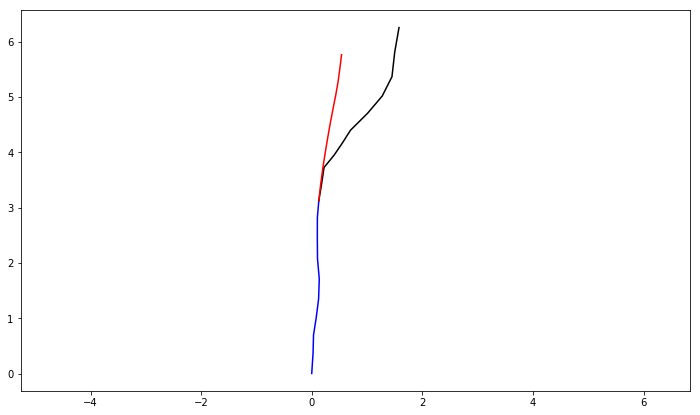

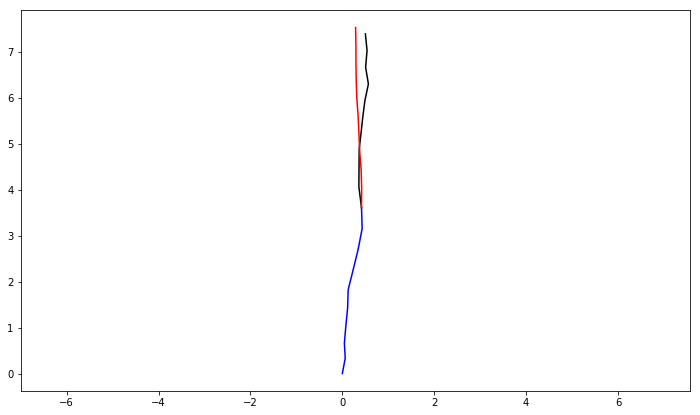

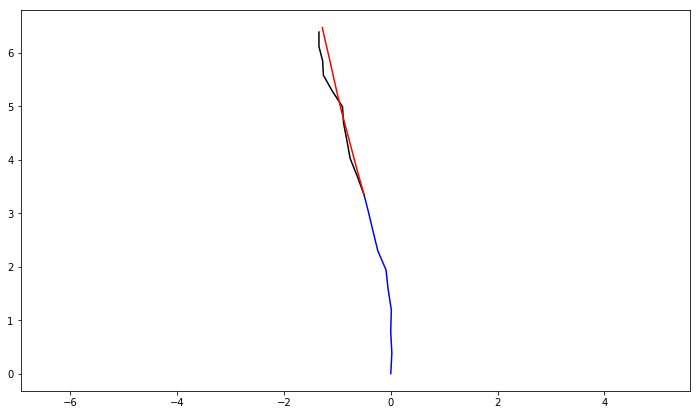

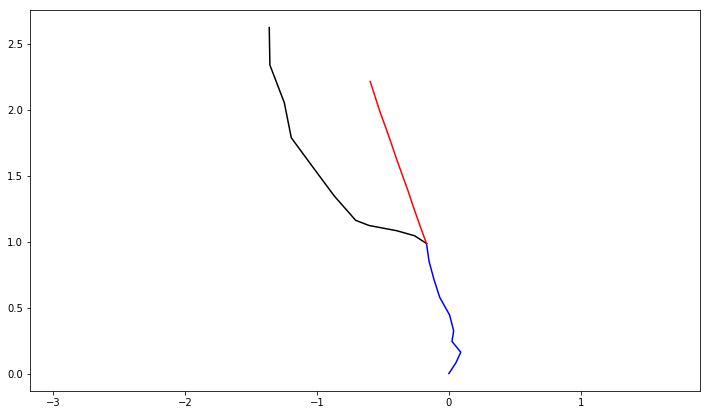

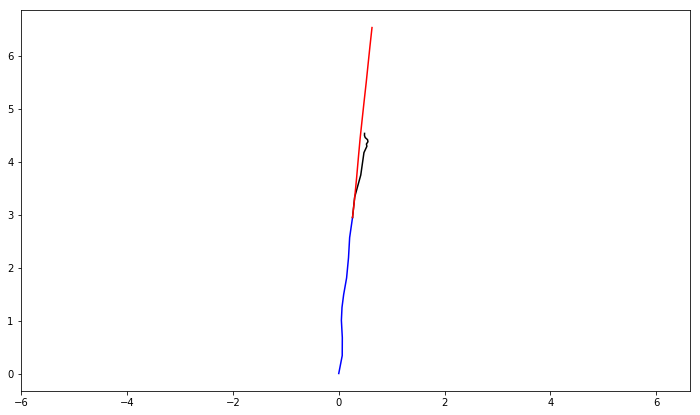

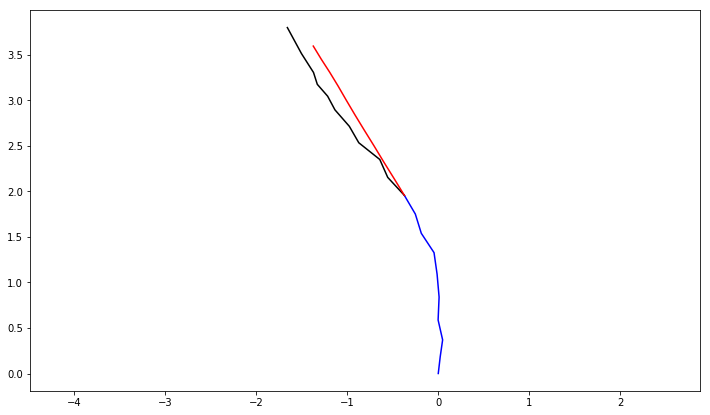

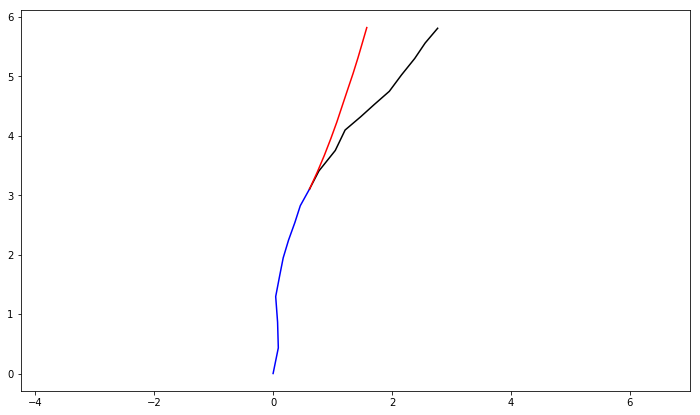

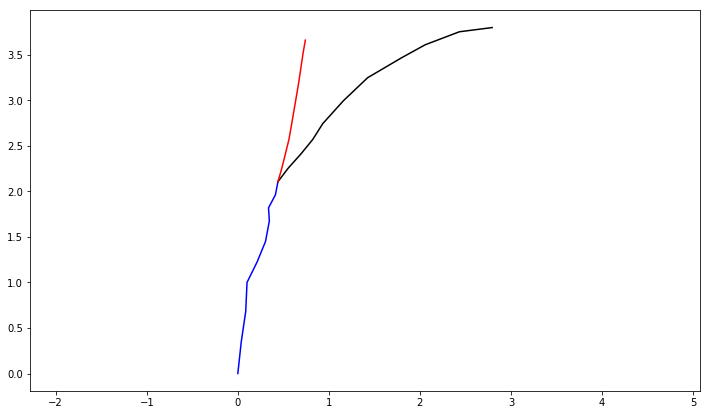

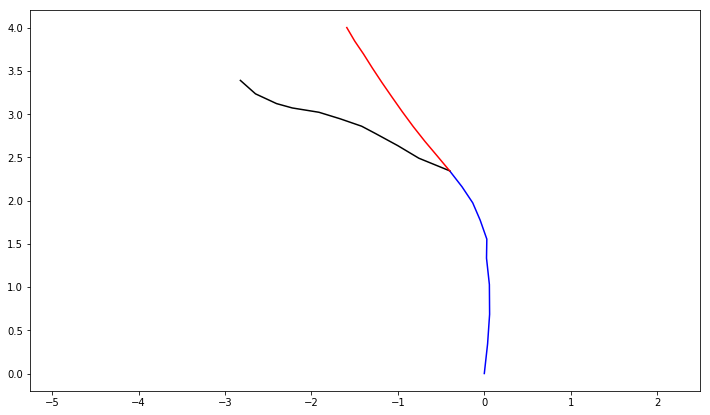

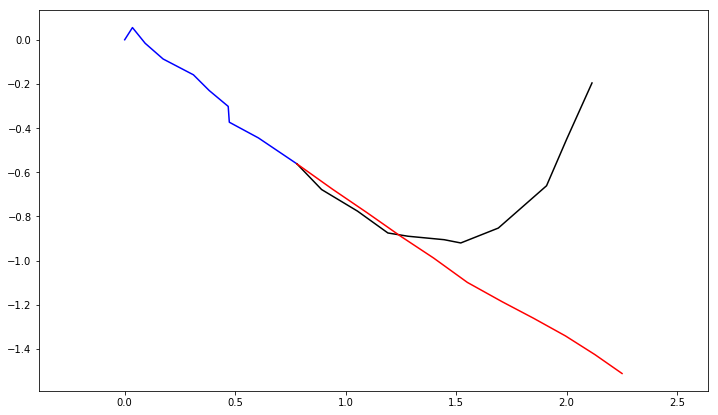

In [74]:
for i in range(10):
    plt.figure(figsize=(12, 7))

    plt.plot(in_coord[(i*20)+3000,:,0],in_coord[(i*20)+3000,:,1],c='b')
    plt.plot(gt_coord[(i*20)+3000,:,0],gt_coord[(i*20)+3000,:,1],c='k')
    plt.plot(output_coord[(i*20)+3000,:,0],output_coord[(i*20)+3000,:,1],c='r')
    plt.axis('equal')
    plt.show()